In [4]:
import numpy as np
import tensorflow as tf
import time
from tqdm import tqdm

# Load data

In [5]:
from sklearn.datasets import fetch_mldata
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score


mnist = fetch_mldata('MNIST original', data_home='./tmp')

# only binary classification supported
mask = (mnist['target'] == 3) + (mnist['target'] == 5)

X_all = scale(mnist['data'][mask].astype(float))
y_all = (mnist['target'][mask]==3)*1

# make it more sparse
X_all = X_all * (np.random.uniform(0, 1, X_all.shape) > 0.8)

print('Dataset shape: {}'.format(X_all.shape))
print('Non-zeros rate: {}'.format(np.mean(X_all != 0)))
print('Classes balance: {} / {}'.format(np.mean(y_all==0), np.mean(y_all==1)))

X_tr, X_te, y_tr, y_te = train_test_split(X_all, y_all, random_state=42, test_size=0.3)

Dataset shape: (13454, 784)
Non-zeros rate: 0.16320197619704935
Classes balance: 0.4692284822357663 / 0.5307715177642337


# Baselines

In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
for model in [
                LogisticRegression(), 
                RandomForestClassifier(n_jobs=-1, n_estimators=200)
            ]:
    model.fit(X_tr, y_tr)
    predictions = model.predict(X_te)
    acc = accuracy_score(y_te, predictions)
    print('model: {}'.format(model.__str__()))
    print('accuracy: {}'.format(acc))
    print()

model: LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
accuracy: 0.8981917265296012

model: RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=200, n_jobs=-1, oob_score=False,
            random_state=None, verbose=0, warm_start=False)
accuracy: 0.8967054743621501



# Dense example

In [7]:
from tffm import TFFMClassifier

for order in [2, 3]:
    model = TFFMClassifier(
        order=order, 
        rank=10, 
        optimizer=tf.train.AdamOptimizer(learning_rate=0.001), 
        n_epochs=50, 
        batch_size=1024,
        init_std=0.001,
        reg=0.01,
        input_type='dense',
        seed=42
    )
    model.fit(X_tr, y_tr, show_progress=True)
    predictions = model.predict(X_te)
    print('[order={}] accuracy: {}'.format(order, accuracy_score(y_te, predictions)))
    # this will close tf.Session and free resources
    model.destroy()  

100%|██████████| 50/50 [00:08<00:00,  6.42epoch/s]


[order=2] accuracy: 0.8929898439435224


100%|██████████| 50/50 [00:08<00:00,  5.42epoch/s]

[order=3] accuracy: 0.9251919742382958


# Sparse example

In [8]:
import scipy.sparse as sp
# only CSR format supported
X_tr_sparse = sp.csr_matrix(X_tr)
X_te_sparse = sp.csr_matrix(X_te)

In [11]:
order = 3
model = TFFMClassifier(
    order=order, 
    rank=10, 
    optimizer=tf.train.AdamOptimizer(learning_rate=0.001), 
    n_epochs=50, 
    batch_size=1024,
    init_std=0.001,
    reg=0.01,
    input_type='sparse',
    seed=42
)
model.fit(X_tr_sparse, y_tr, show_progress=True)
predictions = model.predict(X_te_sparse)
print('[order={}] accuracy: {}'.format(order, accuracy_score(y_te, predictions)))
model.destroy()

100%|██████████| 50/50 [00:06<00:00,  8.43epoch/s]

[order=3] accuracy: 0.9251919742382958


# Regression example

In [13]:
from tffm import TFFMRegressor
from sklearn.metrics import mean_squared_error

model = TFFMRegressor(
    order=order, 
    rank=10, 
    optimizer=tf.train.AdamOptimizer(learning_rate=0.001), 
    n_epochs=50, 
    batch_size=1024,
    init_std=0.001,
    reg=0.01,
    input_type='sparse'
)
# translate Y from {0,1} to {-10, 10}
model.fit(X_tr_sparse, y_tr*20-10, show_progress=True)
predictions = model.predict(X_te_sparse)
print('[order={}] accuracy: {}'.format(order, accuracy_score(y_te, predictions > 0)))
print('MSE: {}'.format(mean_squared_error(y_te*20-10, predictions)))
model.destroy()

100%|██████████| 50/50 [00:06<00:00,  8.29epoch/s]

[order=3] accuracy: 0.9147882090661382
MSE: 75821.57125331472


# n_features/time complexity

In [14]:
n_features = X_all.shape[1]
used_features = range(100, 1000, 100)
n_repeats = 5
elapsed_mean = []
elapsed_std = []
model_title = ''

for cur_n_feats in tqdm(used_features):
    time_observation = []
    for _ in range(n_repeats):
        active_features = np.random.choice(range(n_features), size=cur_n_feats)
        model = TFFMClassifier(
                    order=5, 
                    rank=50,
                    optimizer=tf.train.AdamOptimizer(learning_rate=0.001), 
                    n_epochs=1, 
                    batch_size=-1,
                    init_std=0.01,
                    input_type='dense'
        )
        model_title = model.__str__()
        # manually initialize model without calling .fit()
        model.core.set_num_features(cur_n_feats)
        model.core.build_graph()
        model.initialize_session()
        
        start_time = time.time()
        predictions = model.decision_function(X_all[:, active_features])
        end_time = time.time()
        model.destroy()
        time_observation.append(end_time - start_time)
    elapsed_mean.append(np.mean(time_observation))
    elapsed_std.append(np.std(time_observation))

100%|██████████| 9/9 [02:03<00:00, 13.95s/it]


Populating the interactive namespace from numpy and matplotlib


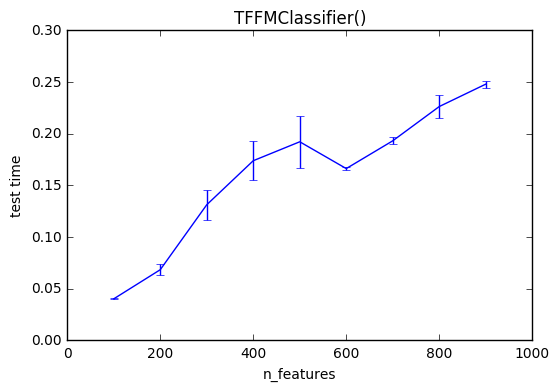

In [15]:
%pylab inline
errorbar(used_features, elapsed_mean, yerr=elapsed_std)
xlim(0, 1000)
title(model_title)
xlabel('n_features')
ylabel('test time')

# Logging example

In [16]:
order = 3
model = TFFMClassifier(
    order=order, 
    rank=10, 
    optimizer=tf.train.AdamOptimizer(learning_rate=0.01), 
    n_epochs=10, 
    batch_size=-1,
    init_std=0.001,
    reg=0.001,
    input_type='sparse',
    log_dir='./tmp/logs',
    verbose=1
)
model.fit(X_tr_sparse, y_tr, show_progress=True)
predictions = model.predict(X_te_sparse)
print('[order={}] accuracy: {}'.format(order, accuracy_score(y_te, predictions)))

  0%|          | 0/10 [00:00<?, ?epoch/s]

Initialize logs, use: 
tensorboard --logdir=/home/mikhail/std/repos/tffm/tmp/logs


100%|██████████| 10/10 [00:01<00:00,  8.30epoch/s]

[order=3] accuracy: 0.8895219222194699


# Save/load example

In [17]:
model.save_state('./tmp/state.tf')
model.destroy()

In [18]:
model = TFFMClassifier(
    order=3, 
    rank=10, 
    optimizer=tf.train.AdamOptimizer(learning_rate=0.01), 
    n_epochs=10, 
    batch_size=-1,
    init_std=0.001,
    reg=0.001,
    input_type='sparse',
    log_dir='./tmp/logs',
    verbose=1
)

# internally model need to allocate memory before load previous weights,
# so need to set num_features explicitly
model.core.set_num_features(X_tr.shape[1])
model.load_state('./tmp/state.tf')

Initialize logs, use: 
tensorboard --logdir=/home/mikhail/std/repos/tffm/tmp/logs


# Different optimizers

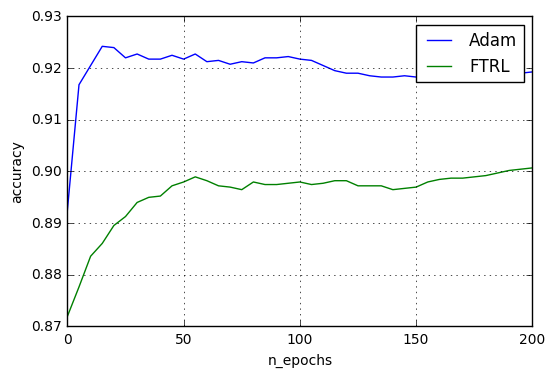

In [20]:
for optim, title in [(tf.train.AdamOptimizer(learning_rate=0.001), 'Adam'), 
              (tf.train.FtrlOptimizer(0.01, l1_regularization_strength=0.01), 'FTRL')]:
    acc = []
    model = TFFMClassifier(
        order=3, 
        rank=10, 
        optimizer=optim,
        batch_size=1024,
        init_std=0.001,
        reg=0.1,
        input_type='sparse',
    )
    n_epochs = 5
    anchor_epochs = range(0, 200+1, n_epochs)
    for _ in anchor_epochs:
        # score result every 5 epochs
        model.fit(X_tr_sparse, y_tr, n_epochs=n_epochs)
        predictions = model.predict(X_te_sparse)
        acc.append(accuracy_score(y_te, predictions))
    plot(anchor_epochs, acc, label=title)
    model.destroy()
xlabel('n_epochs')
ylabel('accuracy')
legend()
grid()

# Different regularization strategies

In [24]:
# only binary classification supported
mask = (mnist['target'] == 3) + (mnist['target'] == 5)

X_all = scale(mnist['data'][mask].astype(float))
y_all = (mnist['target'][mask]==3)*1

# make it more sparse (sparseness is about 97%)
X_all = X_all * (np.random.uniform(0, 1, X_all.shape) > 0.97)

print('Dataset shape: {}'.format(X_all.shape))
print('Non-zeros rate: {}'.format(np.mean(X_all != 0)))
print('Classes balance: {} / {}'.format(np.mean(y_all==0), np.mean(y_all==1)))

X_tr, X_te, y_tr, y_te = train_test_split(X_all, y_all, random_state=42, test_size=0.3)

Dataset shape: (13454, 784)
Non-zeros rate: 0.024494649948577616
Classes balance: 0.4692284822357663 / 0.5307715177642337


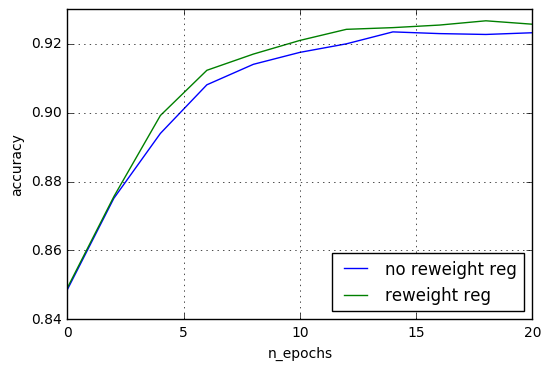

In [25]:
for use_reweight, title in [(False, 'no reweight reg'), (True, 'reweight reg')]:
    acc = []
    model = TFFMClassifier(
        order=3, 
        rank=10, 
        optimizer=tf.train.AdamOptimizer(learning_rate=0.001),
        batch_size=1024,
        init_std=0.001,
        reg=1.0,
        input_type='sparse',
        reweight_reg = use_reweight
    )
    n_epochs = 2
    anchor_epochs = range(0, 20+1, n_epochs)
    for _ in anchor_epochs:
        # score result every 5 epochs
        model.fit(X_tr_sparse, y_tr, n_epochs=n_epochs)
        predictions = model.predict(X_te_sparse)
        acc.append(accuracy_score(y_te, predictions))
    plot(anchor_epochs, acc, label=title)
    model.destroy()
xlabel('n_epochs')
ylabel('accuracy')
legend(loc=4)
grid()